In [1]:
import deepinv as dinv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from tqdm import tqdm

#from PMCPnP import PMCPnP
from utils import get_physics, get_image, get_model

%load_ext autoreload
%autoreload 2

/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EXPERIMENT_DIRECTORY = Path().cwd() / "experiments"
DATA_DIRECTORY = Path().cwd() / "data"
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"


Selected GPU 0 with 24128 MB free memory 


In [44]:
# possible images are "face1", "face2", "face3", "bedroom", "butterfly"
img_size = 256
name = "face1"
image = get_image(DATA_DIRECTORY, name=name, img_size=img_size, device=device)

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


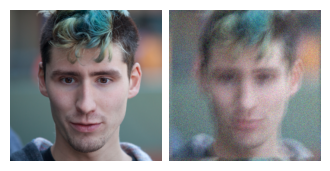

In [48]:
# possible physics are "denoising", "compressed_sensing", "inpainting", "downsampling" and "blur"
transformation_name = "blur"
SIGMA = 0.05
physics = get_physics(transformation_name, img_size, SIGMA, device=device, factor=10)


print(image.shape, physics(image).shape)
dinv.utils.plotting.plot([image, physics(image)])

Best hyperparameters (range):
- PnP: max_iter=200, stepsize=0.1, lambda=0.01
- RED: max_iter=200, stepsize=0.1, lambda=0.01
- DPS: max_iter=1000
- PnP-ULA: max_iter=, stepsize=
- PMCPnP: max_iter=, stepsize=1e-3

In [49]:
model_name = 'DPS'
max_iter = 100
stepsize = 0.05
lambd = 0.01

denoiser = dinv.models.DiffUNet(pretrained="download").to(device)#DiffUNet(large_model=False).to(device)
likelihood = dinv.optim.L2(sigma=SIGMA)

model = get_model(model_name,
                  denoiser, 
                  likelihood, 
                  max_iter=max_iter,
                  stepsize=stepsize,
                  lambd=lambd,
                  sigma=SIGMA,
                  device=device)

In [50]:
x = image.clone()
y = physics(x)

# out, metrics = model(y, physics, x_gt=x, compute_metrics=True)
# print(out.min(), out.max())

pula_mean = model(y, physics)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:06<00:00, 15.96it/s]


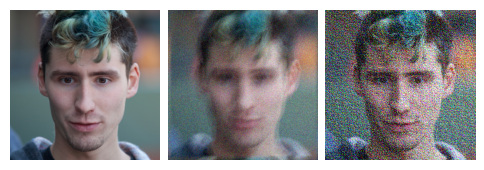

In [7]:
dinv.utils.plotting.plot([x, y, out], rescale_mode='clip')

# True function

In [3]:
def run_experiment(image_name, 
                   transformation_name, 
                   model_name, 
                   max_iter=500, 
                   stepsize=0.05, 
                   lambd=0.01, 
                   sigma=0.05,
                   verbose=True):
    
    img_size = 256
    
    image = get_image(DATA_DIRECTORY, name=image_name, img_size=img_size, device=device)
    if transformation_name == 'downsampling':
        factor = 2
    else:
        factor = 10
    physics = get_physics(transformation_name, 
                          img_size, 
                          sigma, 
                          device=device, 
                          factor=factor)
    y = physics(image)
        
    if model_name in ['PnP', 'RED']:
        denoiser = dinv.models.DRUNet(pretrained="download").to(device)
    else:
        denoiser = dinv.models.DiffUNet(large_model=False).to(device)
        
    likelihood = dinv.optim.L2(sigma=sigma)
    
    model = get_model(model_name,
                        denoiser, 
                        likelihood, 
                        max_iter=max_iter,
                        stepsize=stepsize,
                        lambd=lambd,
                        sigma=sigma,
                        device=device)
    
    if model_name in  ["RED", "PnP"]:
        out, metrics = model(y, physics, x_gt=image, compute_metrics=True)
        if verbose: print(dinv.utils.metric.cal_psnr(out, image))
        return out, metrics, image, y
    
    elif model_name == "DPS":
        out = model(y, physics)
        if verbose: print(dinv.utils.metric.cal_psnr(out, image))
        return out, _, image, y
    
    else:
        mean, var = model(y, physics)
        if verbose: print(dinv.utils.metric.cal_psnr(mean, image))
        return mean, var, image, y
    
    

In [40]:
image_names = [
        "face1", 
        "face2", 
        "face3", 
        "bedroom", 
        "butterfly",
               ]
transformation_names = [
        #"compressed_sensing", 
        "inpainting", 
        "downsampling", 
        "blur",
                        ]
model_names = [
        "RED", 
        "PnP", 
        "DPS", 
        "PnP-ULA", 
        "PMCPnP", 
        "PMCReD", 
        "PMCPnPAnnealing", 
        "PMCReDAnnealing",
               ]

import optuna
def objective(trial):
        #max_iter = trial.suggest_int("max_iter", 100, 1000)
        stepsize = trial.suggest_float("stepsize", 0.0001, 0.01)
        
        out, metrics, image, y = run_experiment(
                                "butterfly", 
                                "blur", 
                                "PMCReD", 
                                max_iter=2000, 
                                verbose=False,
                                stepsize=stepsize,
                                lambd=0.01,
                                sigma=0.05,
                        )
        
        return dinv.utils.metric.cal_psnr(out, image)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print(study.best_params)



[I 2024-03-25 12:01:11,222] A new study created in memory with name: no-name-75c8d25b-ac93-48a9-85ed-6fb2c5ab6b4f


100%|██████████| 2000/2000 [01:01<00:00, 32.78it/s]
[I 2024-03-25 12:02:12,755] Trial 0 finished with value: 13.115349769592285 and parameters: {'stepsize': 0.0070107781604141495}. Best is trial 0 with value: 13.115349769592285.


Monte Carlo sampling finished! elapsed time=61.04 seconds
Iteration 1999, current converge crit. = 7.61E-04, objective = 1.00E-03 
Iteration 1999, current converge crit. = 1.14E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:01<00:00, 32.40it/s]
[I 2024-03-25 12:03:14,994] Trial 1 finished with value: 25.990312576293945 and parameters: {'stepsize': 0.0003293413561536988}. Best is trial 1 with value: 25.990312576293945.


Monte Carlo sampling finished! elapsed time=61.75 seconds
Iteration 1999, current converge crit. = 1.19E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:01<00:00, 32.34it/s]
[I 2024-03-25 12:04:17,338] Trial 2 finished with value: 26.30862808227539 and parameters: {'stepsize': 0.0037606778298533484}. Best is trial 2 with value: 26.30862808227539.


Monte Carlo sampling finished! elapsed time=61.85 seconds
Iteration 1999, current converge crit. = 1.43E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:01<00:00, 32.30it/s]
[I 2024-03-25 12:05:19,767] Trial 3 finished with value: 26.95254898071289 and parameters: {'stepsize': 0.0018137257667973747}. Best is trial 3 with value: 26.95254898071289.


Monte Carlo sampling finished! elapsed time=61.93 seconds
Iteration 1999, current converge crit. = 1.19E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:01<00:00, 32.28it/s]
[I 2024-03-25 12:06:22,239] Trial 4 finished with value: 26.70579719543457 and parameters: {'stepsize': 0.002756904736531818}. Best is trial 3 with value: 26.95254898071289.


Monte Carlo sampling finished! elapsed time=61.97 seconds
Iteration 1999, current converge crit. = 1.30E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:01<00:00, 32.32it/s]
[I 2024-03-25 12:07:24,641] Trial 5 finished with value: 11.780805587768555 and parameters: {'stepsize': 0.009627019378950935}. Best is trial 3 with value: 26.95254898071289.


Monte Carlo sampling finished! elapsed time=61.90 seconds
Iteration 1999, current converge crit. = 8.17E-04, objective = 1.00E-03 
Iteration 1999, current converge crit. = 7.34E-05, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:01<00:00, 32.33it/s]
[I 2024-03-25 12:08:27,025] Trial 6 finished with value: 13.570405960083008 and parameters: {'stepsize': 0.006520411312323362}. Best is trial 3 with value: 26.95254898071289.


Monte Carlo sampling finished! elapsed time=61.88 seconds
Iteration 1999, current converge crit. = 7.36E-04, objective = 1.00E-03 
Iteration 1999, current converge crit. = 1.44E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:01<00:00, 32.31it/s]
[I 2024-03-25 12:09:29,453] Trial 7 finished with value: 25.999135971069336 and parameters: {'stepsize': 0.00037202212650804586}. Best is trial 3 with value: 26.95254898071289.


Monte Carlo sampling finished! elapsed time=61.92 seconds
Iteration 1999, current converge crit. = 1.20E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:01<00:00, 32.27it/s]
[I 2024-03-25 12:10:31,961] Trial 8 finished with value: 16.815383911132812 and parameters: {'stepsize': 0.005479032487046755}. Best is trial 3 with value: 26.95254898071289.


Monte Carlo sampling finished! elapsed time=62.00 seconds
Iteration 1999, current converge crit. = 5.41E-04, objective = 1.00E-03 
Iteration 1999, current converge crit. = 3.49E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:02<00:00, 32.25it/s]
[I 2024-03-25 12:11:34,495] Trial 9 finished with value: 25.936405181884766 and parameters: {'stepsize': 0.004779651994787128}. Best is trial 3 with value: 26.95254898071289.


Monte Carlo sampling finished! elapsed time=62.03 seconds
Iteration 1999, current converge crit. = 1.58E-04, objective = 1.00E-03 
{'stepsize': 0.0018137257667973747}


100%|██████████| 2000/2000 [01:01<00:00, 32.51it/s]


Monte Carlo sampling finished! elapsed time=61.54 seconds
Iteration 1999, current converge crit. = 1.21E-04, objective = 1.00E-03 
26.981033325195312
tensor(0.0642, device='cuda:0') tensor(0.9533, device='cuda:0')


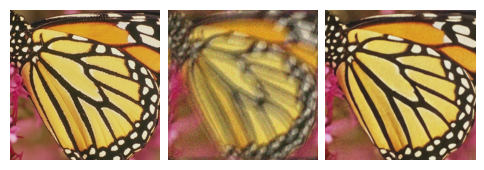

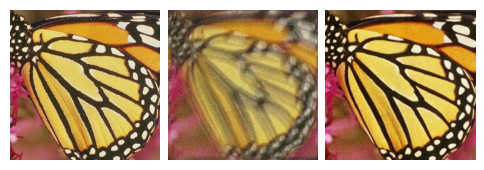

In [41]:
_ = torch.manual_seed(42)
out, metrics, image, y = run_experiment(
                        image_name="butterfly",
                        transformation_name="blur",
                        model_name="PMCReD",
                        max_iter=2000,
                        stepsize=0.0018,
                        lambd=0.01,
                        sigma=0.05
                    )
print(out.min(), out.max())
dinv.utils.plotting.plot([image, y, out], rescale_mode='clip')
dinv.utils.plotting.plot([image, y, out], rescale_mode='min_max')

# SIGMA = 0.05

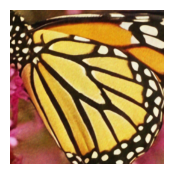

In [42]:
dinv.utils.plotting.plot([out], rescale_mode='min_max')

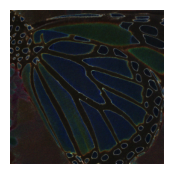

In [43]:
dinv.utils.plotting.plot([metrics], rescale_mode='min_max')

In [18]:
import pickle
pickle.dump(metrics, open(EXPERIMENT_DIRECTORY / "metrics.pkl", "wb"))



Results:

| method | image     | transfo | PSNR | Hyperparameters |
| ------ | -----     | ------- | ---- | --------------- |
| PnP    | butterfly | blur    | 23.0 | step0.1/lambd0.01/150 |
| RED    | butterfly | blur    | 26.4 | step0.1/lambd0.01/400 |
| DPS    | butterfly | blur    | 25.1 | iter260 |
| PnP-ULA| butterfly | blur    | 26.3 | iter2000/step0.003 |
| PMCPnP | butterfly | blur    | 27.1 | iter2000/step0.002555 |
| PMCReD | butterfly | blur    | 26.98 | iter2000/step0.0018 |

In [83]:
import optuna

best_params = {}
for image in image_names:
    for transformation in transformation_names:
        _ = torch.manual_seed(42)
        def objective(trial):
            stepsize = trial.suggest_float("stepsize", 0.001, 0.1)
            lambd = trial.suggest_float("lambd", 0.001, 0.1)
            
            out, _, img = run_experiment(
                        image_name=image,
                        transformation_name=transformation,
                        model_name="RED",
                        max_iter=100,
                        stepsize=stepsize,
                        lambd=lambd,
                        sigma=0.05,
                        verbose=False
                    )
            result = dinv.utils.metric.cal_psnr(out, img)
            return result

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=50)
        
        best_params[(image, transformation, 'RED')] = study.best_params


[I 2024-03-24 20:37:51,976] A new study created in memory with name: no-name-454e21ce-5e86-4d91-b813-a672a24fe575


[I 2024-03-24 20:37:53,547] Trial 0 finished with value: 9.88164234161377 and parameters: {'stepsize': 0.007840422992084553, 'lambd': 0.010278732249140402}. Best is trial 0 with value: 9.88164234161377.
[W 2024-03-24 20:38:22,233] Trial 1 failed with parameters: {'stepsize': 0.0955557025687569, 'lambd': 0.09209023396118365} because of the following error: The value nan is not acceptable.
[W 2024-03-24 20:38:22,233] Trial 1 failed with value nan.
[I 2024-03-24 20:38:25,426] Trial 2 finished with value: -5.4454240798950195 and parameters: {'stepsize': 0.06779159828965244, 'lambd': 0.07725597576401828}. Best is trial 0 with value: 9.88164234161377.
[I 2024-03-24 20:38:28,376] Trial 3 finished with value: 9.952852249145508 and parameters: {'stepsize': 0.017796977438153953, 'lambd': 0.05050196898836775}. Best is trial 3 with value: 9.952852249145508.
[I 2024-03-24 20:38:31,329] Trial 4 finished with value: 9.924784660339355 and parameters: {'stepsize': 0.07009240233050201, 'lambd': 0.021517

In [84]:
best_params

{('face1', 'inpainting', 'RED'): {'stepsize': 0.0838100881560671,
  'lambd': 0.023797889812796916},
 ('face1', 'downsampling', 'RED'): {'stepsize': 0.09999806039919637,
  'lambd': 0.03738675504961055},
 ('face1', 'blur', 'RED'): {'stepsize': 0.08837884434160928,
  'lambd': 0.005670466375249813},
 ('face2', 'inpainting', 'RED'): {'stepsize': 0.0961972296689658,
  'lambd': 0.007629545589980708},
 ('face2', 'downsampling', 'RED'): {'stepsize': 0.09955934551536133,
  'lambd': 0.021453860323378614},
 ('face2', 'blur', 'RED'): {'stepsize': 0.08847018087905745,
  'lambd': 0.0066892847399314895},
 ('face3', 'inpainting', 'RED'): {'stepsize': 0.09311630095275017,
  'lambd': 0.006646960196767569},
 ('face3', 'downsampling', 'RED'): {'stepsize': 0.0999812478954995,
  'lambd': 0.023475406514253023},
 ('face3', 'blur', 'RED'): {'stepsize': 0.08981161243712654,
  'lambd': 0.008414388416743003},
 ('bedroom', 'inpainting', 'RED'): {'stepsize': 0.09882679693317026,
  'lambd': 0.0022895016893214534},
 (

In [85]:
import pickle

with open("best_params_red.pkl", "wb") as f:
    pickle.dump(best_params, f)

In [82]:
best_params_pnp = pickle.load(open("best_params_pnp.pkl", "rb"))

best_params_pnp

{('face1', 'inpainting', 'PnP'): {'stepsize': 0.09960614385223561,
  'lambd': 0.0024408645688944915},
 ('face1', 'downsampling', 'PnP'): {'stepsize': 0.08541453232057948,
  'lambd': 0.05644310558277863},
 ('face1', 'blur', 'PnP'): {'stepsize': 0.0799007546856861,
  'lambd': 0.05917408604690498},
 ('face2', 'inpainting', 'PnP'): {'stepsize': 0.03742454047304258,
  'lambd': 0.013563537658068607},
 ('face2', 'downsampling', 'PnP'): {'stepsize': 0.06319366906061523,
  'lambd': 0.07060473626634452},
 ('face2', 'blur', 'PnP'): {'stepsize': 0.05950797161670624,
  'lambd': 0.08411282292022458},
 ('face3', 'inpainting', 'PnP'): {'stepsize': 0.079096711252473,
  'lambd': 0.007766611010193857},
 ('face3', 'downsampling', 'PnP'): {'stepsize': 0.0646532799199102,
  'lambd': 0.06700733948144955},
 ('face3', 'blur', 'PnP'): {'stepsize': 0.0666381578934626,
  'lambd': 0.07157637200557268},
 ('bedroom', 'inpainting', 'PnP'): {'stepsize': 0.019226935407812187,
  'lambd': 0.02333049998081166},
 ('bedroom